In [1]:
import cv2
import numpy as np
import os
import re
from tqdm import tqdm

import torchvision
import torchvision.transforms as transforms

training_data = []
test_data = []
label = {"cats": 0, "dogs": 1}
image_size = (64,64)

def read_data(path):
    tmp_data = []
    for file in tqdm(os.listdir(path)):
        if re.match("^(cat|dog).[0-9]+.jpg", file):
            full_path = os.path.join(path, file)
            img = cv2.imread(full_path,cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, image_size)
            tmp_data.append([torchvision.transforms.functional.to_tensor(img), label[item_label]])
    return tmp_data

for item_label in label:
    training_data += (read_data("dataset\\training_set\\" + item_label))
    test_data += (read_data("dataset\\test_set\\" + item_label))
                

100%|████████████████████████████████████████████████████████████████████████████| 1013/1013 [00:00<00:00, 1066.28it/s]


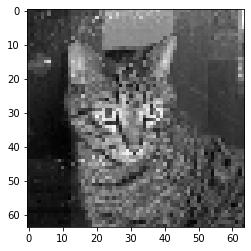

In [2]:
# Check image
import matplotlib.pyplot as plt
plt.imshow(training_data[0][0].numpy().reshape(64,64), cmap='gray')

In [3]:
# Check label
print(list(label.keys())[list(label.values()).index(training_data[0][1])])

cats


In [4]:
print(len(training_data))
print(len(test_data))

8000
2000


In [5]:
print(training_data[0])

[tensor([[[0.1686, 0.1647, 0.1412,  ..., 0.3137, 0.4980, 0.7608],
         [0.1569, 0.1490, 0.1725,  ..., 0.3490, 0.4863, 0.7490],
         [0.1529, 0.1451, 0.2353,  ..., 0.3922, 0.4902, 0.7804],
         ...,
         [0.0902, 0.0824, 0.0941,  ..., 0.2706, 0.3137, 0.1961],
         [0.0784, 0.0745, 0.0863,  ..., 0.0980, 0.2275, 0.2039],
         [0.1020, 0.0902, 0.0902,  ..., 0.2824, 0.2667, 0.1137]]]), 0]


In [192]:
import torch 
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #CUDA is a GPU

input_size = 64*64
num_classes = 2
num_epochs = 20
batch_size = 100
learning_rate = 0.001

train_loader = torch.utils.data.DataLoader(dataset=training_data, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [193]:
class ConvNet(nn.Module):
    def __init__(self, num_classes = 2):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(2304, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [194]:
#training
model = ConvNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))


Epoch [1/20], Step [20/80], Loss: 0.6904
Epoch [1/20], Step [40/80], Loss: 0.6910
Epoch [1/20], Step [60/80], Loss: 0.6315
Epoch [1/20], Step [80/80], Loss: 0.6563
Epoch [2/20], Step [20/80], Loss: 0.6127
Epoch [2/20], Step [40/80], Loss: 0.6279
Epoch [2/20], Step [60/80], Loss: 0.5989
Epoch [2/20], Step [80/80], Loss: 0.5974
Epoch [3/20], Step [20/80], Loss: 0.5860
Epoch [3/20], Step [40/80], Loss: 0.4717
Epoch [3/20], Step [60/80], Loss: 0.5374
Epoch [3/20], Step [80/80], Loss: 0.5247
Epoch [4/20], Step [20/80], Loss: 0.4594
Epoch [4/20], Step [40/80], Loss: 0.3755
Epoch [4/20], Step [60/80], Loss: 0.4784
Epoch [4/20], Step [80/80], Loss: 0.4950
Epoch [5/20], Step [20/80], Loss: 0.4003
Epoch [5/20], Step [40/80], Loss: 0.4148
Epoch [5/20], Step [60/80], Loss: 0.5618
Epoch [5/20], Step [80/80], Loss: 0.4598
Epoch [6/20], Step [20/80], Loss: 0.3459
Epoch [6/20], Step [40/80], Loss: 0.3096
Epoch [6/20], Step [60/80], Loss: 0.3778
Epoch [6/20], Step [80/80], Loss: 0.3557
Epoch [7/20], St

In [197]:
#testing
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 2000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 2000 test images: 86.4 %


In [ ]:
## SVM

In [5]:
training_data_flat = np.array([training_data[i][0].numpy().flatten() for i in range(len(training_data))])
test_data_flat = np.array([test_data[i][0].numpy().flatten() for i in range(len(test_data))])
training_y = np.array([training_data[i][1] for i in range(len(training_data))])
test_y = np.array([test_data[i][1] for i in range(len(test_data))])

In [6]:
test_y

array([0, 0, 0, ..., 1, 1, 1])

In [7]:
from sklearn.svm import SVC

model = SVC(kernel='rbf',verbose=True)

In [8]:
import time
start_time = time.time()
model.fit(training_data_flat, training_y)
print(time.time() - start_time)

[LibSVM]294.23169326782227


In [12]:
from sklearn.metrics import accuracy_score
start_time = time.time()
predicted = model.predict(test_data_flat)
print(accuracy_score(test_y, predicted))
print(time.time() - start_time)

0.6525
71.40791583061218


In [ ]:
## Ensemble SVM

In [ ]:
from sklearn.ensemble import BaggingClassifier
model = BaggingClassifier(SVC(kernel='rbf'), n_estimators=10)
start_time = time.time()
model.fit(training_data_flat, training_y)
print(time.time() - start_time)

In [ ]:
from sklearn.metrics import accuracy_score
start_time = time.time()
predicted = model.predict(test_data_flat)
print(accuracy_score(test_y, predicted))
print(time.time() - start_time)